In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
kidney_df_pd = pd.read_csv(r'.\Kidney disease.csv')
kidney_df = np.asarray(kidney_df_pd)

In [3]:
kidney_df_pd.columns = ['pregnancy', 'glucose', 'blood_pressure', 'heart rate', 
              'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age', 'result']

In [4]:
print(kidney_df_pd.keys())

Index(['pregnancy', 'glucose', 'blood_pressure', 'heart rate',
       'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age',
       'result'],
      dtype='object')


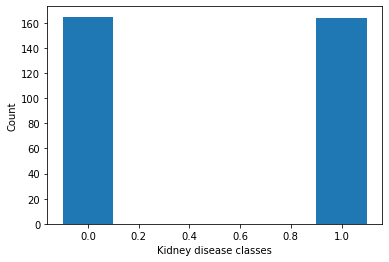

In [5]:
#get the classes distribution.
plt.hist(kidney_df[:,-1], bins =[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Kidney disease classes')
plt.ylabel('Count')
plt.show()

In [6]:
labels = ['pregnancy', 'glucose', 'blood_pressure', 'heart rate', 
              'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']

In [7]:
class0 = kidney_df[kidney_df[:,9] == 0]
class1 = kidney_df[kidney_df[:,9] == 1]

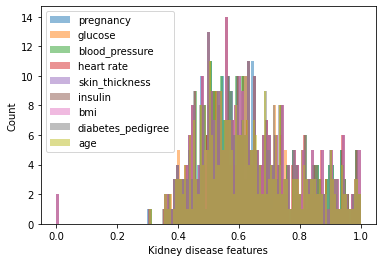

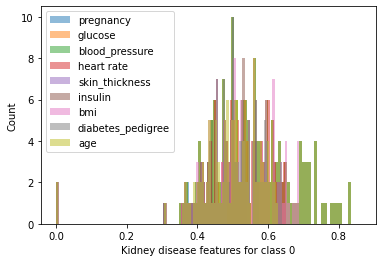

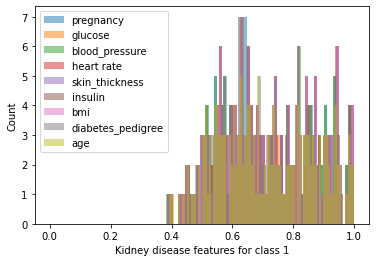

In [8]:
for i in range(len(kidney_df[0])-1):
  bins = np.linspace(min(kidney_df[i,:]), max(kidney_df[i,:]), 100)
  plt.hist(kidney_df[:,1], bins, alpha = 0.5, label = (labels[i]))
  plt.xlabel('Kidney disease features')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

for i in range(len(class0[0])-1):
  bins = np.linspace(min(class0[i,:]), max(class0[i,:]), 100)
  plt.hist(class0[:,1], bins, alpha = 0.5, label = (labels[i]))
  plt.xlabel('Kidney disease features for class 0')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

for i in range(len(class1[0])-1):
  bins = np.linspace(min(class1[i,:]), max(class1[i,:]), 100)
  plt.hist(class1[:,1], bins, alpha = 0.5, label = (labels[i]))
  plt.xlabel('Kidney disease features for class 1')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

In [9]:
average_of_features = np.mean(kidney_df[:,:9], axis=0)
print(average_of_features)
average_of_class_0 = np.mean(class0[:,:9], axis=0)
average_of_class_1 = np.mean(class1[:,:9], axis=0)

[0.24083674 0.63571663 0.57912657 0.21430108 0.10660218 0.48913088
 0.17781166 0.22375905 0.44021502]


average of features for all data


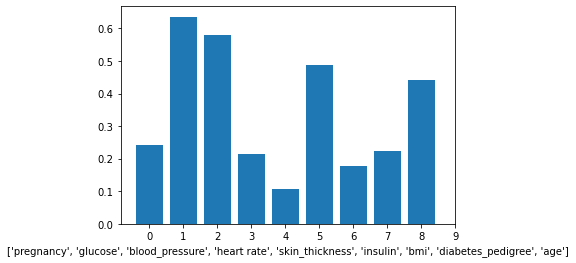

average of features for class 0 data


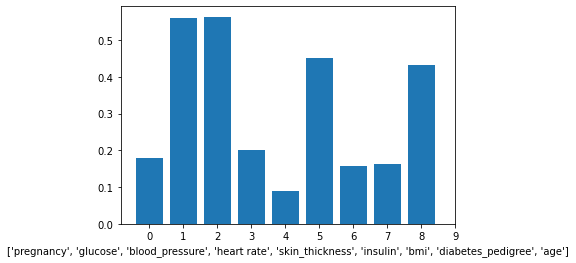

average of features for class 1 data


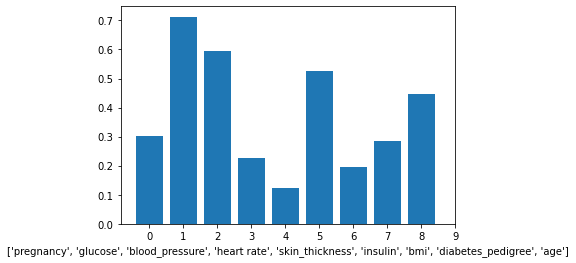

In [10]:
print("average of features for all data")
features = np.arange(0,10)
plt.bar(range(len(average_of_features)), average_of_features)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

print("average of features for class 0 data")
features = np.arange(0,10)
plt.bar(range(len(average_of_class_0)), average_of_class_0)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

print("average of features for class 1 data")
features = np.arange(0,10)
plt.bar(range(len(average_of_class_1)), average_of_class_1)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

Standard deviation for data


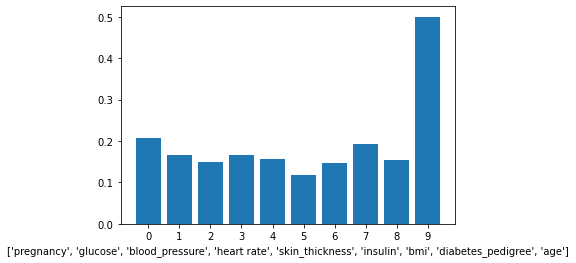

In [11]:
std = np.std(kidney_df, axis = 0)
print("Standard deviation for data")
features = np.arange(0,10)
plt.bar(range(len(std)), std)
plt.xticks(range(len(features)), features)
plt.xlabel(labels)
plt.show()

In [141]:


class Model:
    
    def __init__(self, data):
        np.random.seed(4)
        np.random.shuffle(data)                     #shuffle the rows
        self.full = np.asarray(data)
        self.data = data[:,:-1]                     #all columns up to last column are features data 
        self.target = data[:,-1].reshape(-1,1)      #last column is the target data convert to column vector
    
    def split_data(self, data, test_size=0.3, shuffle=False, random_state=None):
        # Shuffle data if requested
        if shuffle:
            if random_state is not None:
                np.random.seed(random_state)
            data_shuffled = np.random.shuffle(data)
        else:
            data_shuffled = data
 
        # Split data into training and testing sets
        split_index = int((1 - test_size) * data.shape[0])
        train_set = data_shuffled[:split_index]
        test_set = data_shuffled[split_index:]
        
        return train_set, test_set
    
    def add_dummy_feature(self, X):
        dummy_feature = np.ones(X.shape[0]).reshape(-1,1)
        X = np.hstack((X,dummy_feature))
        return X

    def remove_feature(self, X, feature_number = 0):
        X = np.delete(X, feature_number, axis=1)
        return X

    def sorting_by_class(self,X_training, y_training):
        data = np.hstack((X_training,y_training))
        class0 = data[data[:,9] == 0]
        class1 = data[data[:,9] == 1]
        combined = np.concatenate((class0, class1), axis=0)
        y_train = combined[:,-1].reshape(-1,1)
        X_train = combined[:,:-1]
        return X_train, y_train

    def fit_LDA(self, x_train, y_train):
        
        x,y = self.sorting_by_class(x_train,y_train)
        num_targets = np.unique(y, return_counts=True)
        N0 = num_targets[1][0]
        N1 = num_targets[1][1]
        Py0 = N0/(N1+N0)
        Py1 = N1/(N1+N0)

        mu0 = (x[y[:,0]== 0,:]).mean(0)
        mu1 = (x[y[:,0]== 1,:]).mean(0)
        mu0_r = np.tile(mu0, (N0,1))
        mu1_r = np.tile(mu1, (N1,1))
        mu = np.concatenate((mu0_r, mu1_r), axis = 0)

        sigma = (x - mu).T@(x - mu)/(N0+N1 - 2)
        sigma_inv = np.linalg.pinv(sigma)
        return Py0, Py1, mu0, mu1, sigma_inv


    def predict_LDA(self, Py0, Py1, mu0, mu1, sigma_inv, X_test, threshold=0.5):

        y_predict = []
        for i in range (X_test.shape[0] ):
          a = math.log(Py1/Py0) - 0.5*mu1.T@sigma_inv@mu1 + 0.5*mu0.T@sigma_inv@mu0 + X_test[i].T@sigma_inv@(mu1-mu0)
          sigmoid = 1/(1+np.exp(-a))
          if sigmoid>=threshold:
            y_predict.append(1)
          else:
            y_predict.append(0)
        return y_predict


    def fit_GD(self, x_train, y_train, l_rate, error_thresh, _lambda):

        w = np.zeros(len(x_train[0]))
        y_train = y_train.flatten()
        def gradient(w):
          a = x_train @ w
          delta = - (y_train - 1/(1+np.exp(-a))).T@x_train + _lambda*np.sign(w)
          return delta

        counter = 0
        error = 2*error_thresh
        w_old = []
        while error >= error_thresh and counter < 10000:
          g = gradient(w)
          w_old = w
          w =  w - l_rate * g
          error = np.linalg.norm((w-w_old),2)
          counter += 1
        return w


    def predict_GD(self, x_train, w_train, threshold):

        x = np.asarray(x_train)
        w = np.asarray(w_train)
        a = x @ w
        sigmoid = 1 / (1 + np.exp(-a))
        y_predict = [int(s >=threshold) for s in sigmoid]
        return y_predict


    def accu_eval(self, y_val, y_predict):
        acc = np.asarray([int(y_val[i] == y_predict [i]) for i in range(len(y_val))])
        return acc.mean()

    def k_fold_cross(self, X_complete, y_complete, trainig_alg=0, l_rate=0.001, _lambda=0.01, threshold = 0.5):

        k=10
        accuracy_list =  []
        fold_size = int(len(X_complete)/k)
        number_examples_rounded = fold_size*k
        for i in range(0, number_examples_rounded, fold_size): 
          if(i == number_examples_rounded-fold_size):
            X_train=X_complete[:i,:]
            X_val=X_complete[i:,:]
            y_train=y_complete[:i,:]
            y_val=y_complete[i:,:]
          else:
            X_train=np.delete(X_complete, slice(i,i+fold_size),0) 
            X_val=X_complete[i:i+fold_size,:]  
            y_train=np.delete(y_complete,slice(i,i+fold_size),0)
            y_val=y_complete[i:i+fold_size,:]

          if(trainig_alg == 0):
            algorithm = "Gradient Descent"
            w_trained = self.fit_GD(X_train, y_train, l_rate, 0.001,_lambda)
            y_predict = self.predict_GD(X_val,w_trained, 0.5)
          if(trainig_alg == 1):
            algorithm = "LDA"
            Py0, Py1, mu0, mu1, sigma_inv = self.fit_LDA(X_train, y_train)
            y_predict = self.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, X_val, threshold)
          accuracy = self.accu_eval(y_val,y_predict)
          accuracy_list.append(accuracy) 
        accuracy_mean = np.mean(accuracy_list)
        return accuracy_mean, accuracy_list, algorithm


In [142]:
import copy
import time

def run_GD():
    dataset = kidney_df
    model = Model(dataset) #lp_data aq_data
    x = []
    y = []
    z = []
    X_complete = []
    X_clone = []
    best_lr = 0
    max_mean = 0
    X_clone = copy.deepcopy(model.data)
    X_complete = model.add_dummy_feature(X_clone)
    for i in range(-5,1,1):
        l_rate = 10**i
        start = time.time()
        mean, by_fold, algorithm_used = model.k_fold_cross(X_complete, model.target, 0, l_rate)
        end = time.time()
        if(mean >= max_mean):
            best_lr = l_rate
            max_mean = mean
        x.append(l_rate)
        z.append(end-start)
        y.append(mean)

    print("l_rate ", x)
    plt.plot(x,y)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(x,z)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Simulation Time [s]')
    plt.show()
    print(best_lr, max(y))
    return best_lr, max(y)


l_rate  [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]


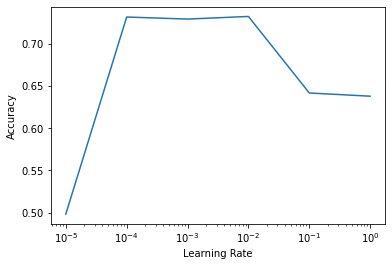

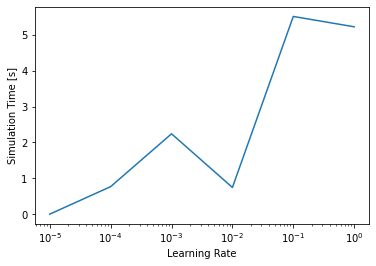

0.01 0.7321646341463415
0.7321646341463415


In [143]:
best_lr, gd_accuracy = run_GD() # Run gradient descent
print(gd_accuracy)

In [144]:
def run_LDA():
    dataset = kidney_df
    model_lda = Model(dataset) 
    x = []
    y = []
    z = []
    X_complete = []
    X_clone = []
    t_s = np.linspace(0,1,100)
    best_threshold_LDA = 0
    max_mean = 0.0
    X_clone = copy.deepcopy(model_lda.data)
    # X_complete = model.basis_expansion(X_clone, 1, best_order,best_feature)
    for i in range(len(t_s)):
      threshold = t_s[i]
      start = time.time()
      mean, by_fold, algorithm_used = model_lda.k_fold_cross(X_clone, model_lda.target,1,0.001, 0.01, threshold)
      if(mean > max_mean):
        best_threshold_LDA = threshold
        max_mean = mean
      end = time.time()
      x.append(threshold)
      z.append(end-start)
      y.append(mean)

    plt.plot(x,y)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(x,z)
    plt.xlabel('Threshold')
    plt.ylabel('Simulation Time [s]')
    plt.show()
    print(best_threshold_LDA, max(y))
    return best_threshold_LDA, max(y)

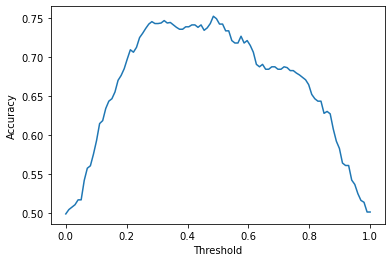

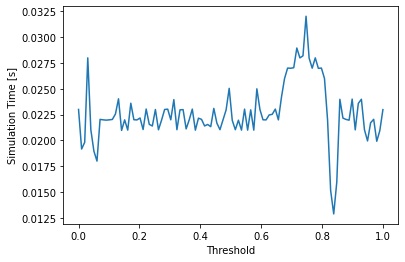

0.48484848484848486 0.7526676829268293
0.7526676829268293


In [145]:
best_threshold_LDA, lda_accuracy = run_LDA()
print(lda_accuracy)

average of features for all data [0.7321646341463415, 0.7526676829268293]


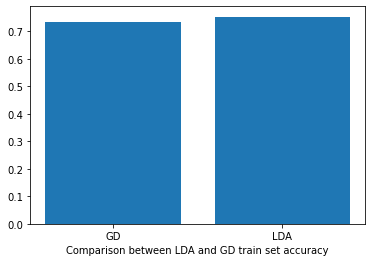

In [146]:
gd_lda = [gd_accuracy, lda_accuracy]
print("average of features for all data", gd_lda)
features = ["GD", "LDA"]
plt.bar(range(len(features)), gd_lda)
plt.xticks(range(len(features)), features)
plt.xlabel("Comparison between LDA and GD train set accuracy")
plt.show()


(329, 10)


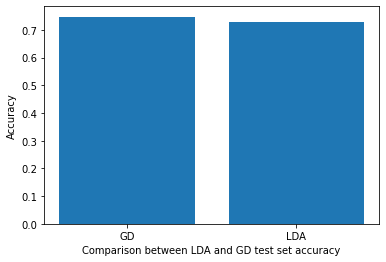

['GD', 'LDA']
test accuracy: [0.7474747474747475, 0.7272727272727273]
train accuracy: [0.7478260869565218, 0.7347826086956522]


In [149]:
x = []
y = []
z = []
y_p_tr = []
X_complete = []

t_s = np.linspace(0,1,11)

learning_alg = ""
model = Model(kidney_df)

#train and test using the GD model
X_clone = []
X_clone = copy.deepcopy(kidney_df)
print(np.shape(X_clone))
X_complete = []
train_set, test_set = model.split_data(X_clone)
x_train = train_set[:,:-1]
x_test = test_set[:,:-1]
y_train = train_set[:,-1].reshape(-1,1)
y_test = test_set[:,-1].reshape(-1,1)
x_train = model.add_dummy_feature(x_train) 
x_test = model.add_dummy_feature(x_test)  
w_trained = model.fit_GD(x_train, y_train, best_lr, 0.001, best_reg)
y_predict_train = model.predict_GD(x_train, w_trained, 0.5)
y_predict = model.predict_GD(x_test, w_trained, 0.5)
mean = model.accu_eval(y_test,y_predict)
mean_train = model.accu_eval(y_train,y_predict_train)
learning_alg = "GD"
x.append(learning_alg)
y.append(mean)
y_p_tr.append(mean_train)


model2 = Model(kidney_df)

#train and test using the LDA model
X_clone = []
X_clone = copy.deepcopy(kidney_df)

train_set, test_set = model2.split_data(X_clone)
x_train = train_set[:,:-1]
x_test = test_set[:,:-1]

y_train = train_set[:,-1].reshape(-1,1)
y_test = test_set[:,-1].reshape(-1,1)
Py0, Py1, mu0, mu1, sigma_inv = model2.fit_LDA(x_train, y_train)
y_predict = model2.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, x_test, best_threshold_LDA)
y_predict_train = model2.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, x_train, best_threshold_LDA)
mean = model2.accu_eval(y_test,y_predict)
mean_train = model2.accu_eval(y_train,y_predict_train)
learning_alg = "LDA"
x.append(learning_alg)
y.append(mean)
y_p_tr.append(mean_train)
  
plt.bar(x,y)
plt.xlabel("Comparison between LDA and GD test set accuracy")
plt.ylabel('Accuracy')
plt.show()
print(x)
print("test accuracy:", y)
print("train accuracy:", y_p_tr)

In [18]:
class Model2:
    def __init__(self, data):
        self.X = data[:,:-1]                     #all columns up to last column are features data 
        self.y = data[:,-1].reshape(-1,1)      #last column is the target data convert to column vector
        self.model = None
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
    
    
    def fit(self, X):
        arr = np.concatenate()
         # Compute class means and scatter matrices
        means = [(X[self.y_train[:,0]== 0,:]).mean(0) for label in np.unique(self.y_train)]
        scatter_within = sum([np.cov(X[self.y == label], rowvar=False) for label in np.unique(self.y)])
        scatter_between = sum([len(X[self.y == label]) * np.outer(means[i] - np.mean(X, axis=0), means[i] - np.mean(X, axis=0)) for i, label in enumerate(np.unique(self.y))])
        
        # Compute eigenvectors and sort by eigenvalue
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(scatter_within).dot(scatter_between))
        eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        
        # Select eigenvectors corresponding to the largest eigenvalues
        self.w = np.hstack([eig_pairs[i][1].reshape(self.n_features, 1) for i in range(self.n_classes - 1)])
    
    def predict(self, X):
#         if self.model is None:
#             raise ValueError('Model has not been fit yet')
        scores = np.dot(X, np.array(self.w).T) + self.b
        return np.argmax(scores, axis=1)
    
    def kfold_cv(self, k=10, shuffle=True, random_state=None):
        n_samples = self.X.shape[0]
        indices = np.arange(n_samples)

        if shuffle:
            np.random.seed(random_state)
            np.random.shuffle(indices)

        fold_sizes = np.full(k, n_samples // k, dtype=np.int)
        fold_sizes[:n_samples % k] += 1

        current = 0
        scores = []

        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            train_indices = np.concatenate((indices[:start], indices[stop:]))

#             X_train, y_train = self.X[train_indices], self.y[train_indices]
#             X_test, y_test = self.X[test_indices], self.y[test_indices]

            self.fit(self.X_train)
            score = self.score(X_test, y_test)
            scores.append(score)

            current = stop

        return scores
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def train_test_split(self, test_size=0.3, shuffle=False, random_state=None):
        # Shuffle data if requested
        if shuffle:
            if random_state is not None:
                np.random.seed(random_state)
            idx = np.random.permutation(len(self.X))
            X_shuffled = self.X[idx]
            y_shuffled = self.y[idx]
        else:
            X_shuffled = self.X
            y_shuffled = self.y
        
        # Split data into training and testing sets
        split_index = int((1 - test_size) * len(self.X))
        X_train = X_shuffled[:split_index]
        y_train = y_shuffled[:split_index]
        X_test = X_shuffled[split_index:]
        y_test = y_shuffled[split_index:]
        
        return X_train, X_test, y_train, y_test

In [19]:
t_s = np.linspace(0,1,100)
model_lda = Model2(kidney_df) 
print(model_lda.X_train.shape)
print(model_lda.y_train.shape)

for feature in range(len(t_s)):
    scores = model_lda.kfold_cv(k=10, shuffle=True, random_state=42)
    print(scores)

(230, 9)
(230, 1)


<ipython-input-18-f5a599730aa9>:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(k, n_samples // k, dtype=np.int)


TypeError: only integer scalar arrays can be converted to a scalar index